# **Task 1**

---

## **EDA and Data Preprocessing**

The overall goal is to build a predictive model for customer chur. Specifically, this task will involve gathering relevant data, conducting EDA, and preparing the data set for model development.

The output is a comprehensive report detailing your data gathering, EDA, and data cleaning processes. The report should include:
- A summary of the data sets selected and the rationale for their inclusion

- Visualisations and statistical summaries from the EDA
- A description of the data cleaning and preprocessing steps taken
- The cleaned and preprocessed data set ready for model building


### **Exploratory data analysis**

First, we must load all sheets in order to better understand what we have and the statistical properties of the dataset.

In [12]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore Warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load Excel file
file_path = "Data/Customer_Churn_Data_Large.xlsx"
xlsx = pd.ExcelFile(file_path)

In [3]:
# Load sheets into separate DataFrames
demographics = xlsx.parse("Customer_Demographics")
transactions = xlsx.parse("Transaction_History")
service = xlsx.parse("Customer_Service")
online = xlsx.parse("Online_Activity")
churn = xlsx.parse("Churn_Status")

Now we can start merging all the sheets by `CustomerID` column. To tackle the problem of **transactional format** of `Transaction_History` and `Customer_Service` sheets, I will aggregate the transactional data first using `.groupby('CustomerID')` and applied functions like _sum_, _count_, and _mean_.

This turned the transactional sheets into **customer-level summaries** (i.e., each row = one customer), making it possible to:

- Merge them safely with `Customer_Demographics`, `Online_Activity`, and `Churn_Status`.

- Do EDA with one observation per customer.

- Fit a proper model. 

In [4]:
# Aggregate transactional and service data first
trans_agg = transactions.groupby("CustomerID").agg({
    "AmountSpent": ["sum", "mean", "count"],
    "TransactionID": "nunique"
})
trans_agg.columns = ['TotalSpent', 'AvgSpent', 'NumTransactions', 'UniqueTransactions']

service_agg = service.groupby("CustomerID").agg({
    "InteractionID": "count",
    "ResolutionStatus": lambda x: (x == 'Resolved').mean()
})
service_agg.columns = ['ServiceInteractions', 'ResolutionRate']

# Merge all together
base_df = demographics.merge(trans_agg, on="CustomerID", how="left")
base_df = base_df.merge(service_agg, on="CustomerID", how="left")
base_df = base_df.merge(online, on="CustomerID", how="left")
base_df = base_df.merge(churn, on="CustomerID", how="left")

The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [5]:
base_df.head()

,CustomerID,Age,Gender,MaritalStatus,IncomeLevel,TotalSpent,AvgSpent,NumTransactions,UniqueTransactions,ServiceInteractions,ResolutionRate,LastLoginDate,LoginFrequency,ServiceUsage,ChurnStatus
0,1,62,M,Single,Low,416.50,416.50000,1,1,1.0,1.0,2023-10-21,34,Mobile App,0
1,2,65,M,Married,Low,1547.42,221.06000,7,7,1.0,1.0,2023-12-05,5,Website,1
2,3,18,M,Single,Low,1702.98,283.83000,6,6,1.0,1.0,2023-11-15,3,Website,0
3,4,21,M,Widowed,Low,917.29,183.45800,5,5,2.0,0.5,2023-08-25,2,Website,0
4,5,21,M,Divorced,Medium,2001.49,250.18625,8,8,NaN,NaN,2023-10-27,41,Website,0


In [6]:
# Dataset dimensions and data types
base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CustomerID           1000 non-null   int64         
 1   Age                  1000 non-null   int64         
 2   Gender               1000 non-null   object        
 3   MaritalStatus        1000 non-null   object        
 4   IncomeLevel          1000 non-null   object        
 5   TotalSpent           1000 non-null   float64       
 6   AvgSpent             1000 non-null   float64       
 7   NumTransactions      1000 non-null   int64         
 8   UniqueTransactions   1000 non-null   int64         
 9   ServiceInteractions  668 non-null    float64       
 10  ResolutionRate       668 non-null    float64       
 11  LastLoginDate        1000 non-null   datetime64[ns]
 12  LoginFrequency       1000 non-null   int64         
 13  ServiceUsage         1000 non-null

In [7]:
# Statistical summary of numerical features
base_df.describe()

,CustomerID,Age,TotalSpent,AvgSpent,NumTransactions,UniqueTransactions,ServiceInteractions,ResolutionRate,LastLoginDate,LoginFrequency,ChurnStatus
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,668.000000,668.000000,1000,1000.000000,1000.000000
mean,500.500000,43.267000,1267.074950,248.806511,5.054000,5.054000,1.500000,0.527695,2023-07-05 21:28:48,25.912000,0.204000
min,1.000000,18.000000,9.800000,9.800000,1.000000,1.000000,1.000000,0.000000,2023-01-01 00:00:00,1.000000,0.000000
25%,250.750000,30.000000,626.685000,203.734167,3.000000,3.000000,1.000000,0.000000,2023-04-08 00:00:00,13.750000,0.000000
50%,500.500000,43.000000,1232.880000,250.121458,5.000000,5.000000,1.500000,0.500000,2023-07-10 12:00:00,27.000000,0.000000
75%,750.250000,56.000000,1791.902500,295.023854,7.000000,7.000000,2.000000,1.000000,2023-10-01 06:00:00,38.000000,0.000000
max,1000.000000,69.000000,3386.040000,496.990000,9.000000,9.000000,2.000000,1.000000,2023-12-31 00:00:00,49.000000,1.000000
std,288.819436,15.242311,738.590013,79.372766,2.603433,2.603433,0.500375,0.421921,NaN,14.055953,0.403171


Let's check if missing values still exist in the dataset.

In [8]:
# Check for missing values
base_df.isnull().sum()

CustomerID               0
Age                      0
Gender                   0
MaritalStatus            0
IncomeLevel              0
TotalSpent               0
AvgSpent                 0
NumTransactions          0
UniqueTransactions       0
ServiceInteractions    332
ResolutionRate         332
LastLoginDate            0
LoginFrequency           0
ServiceUsage             0
ChurnStatus              0
dtype: int64

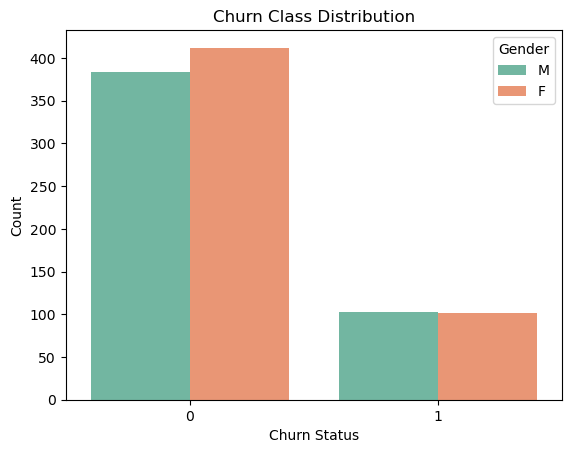

In [39]:
sns.countplot(data=base_df, x="ChurnStatus", hue="Gender", palette="Set2")
plt.title("Churn Class Distribution")
plt.xlabel("Churn Status")
plt.ylabel("Count")
plt.show()

**Interpretation:**

- **Churn Rate**: The number of churned customers (`ChurnStatus = 1`) is significantly lower than retained customers (`ChurnStatus = 0`). This class imbalance should be addressed later (e.g., via SMOTE or class weights).

- **Gender Breakdown**: Churn behavior appears evenly distributed across genders — no major skew toward male or female. This suggests gender alone may not be a strong predictor, but could still interact with other variables.

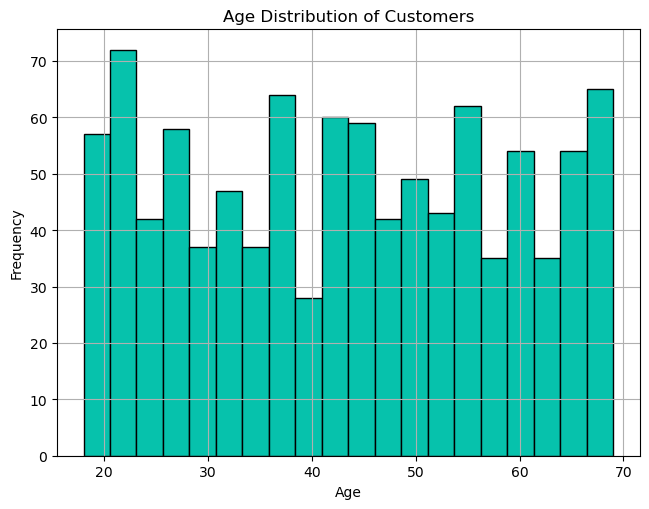

In [63]:
# Histograms
base_df["Age"].hist(bins= 20, color='#06C2AC', edgecolor='black')
plt.tight_layout()
plt.title("Age Distribution of Customers")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

**Interpretation:**

- The age distribution is broad and fairly uniform, ranging from ~18 to ~70.

- No specific age group dominates — the customer base spans multiple generations.

- **Implication**: Age is suitable for modeling (wide range, decent variance), and may interact with usage/spending behavior or churn patterns.

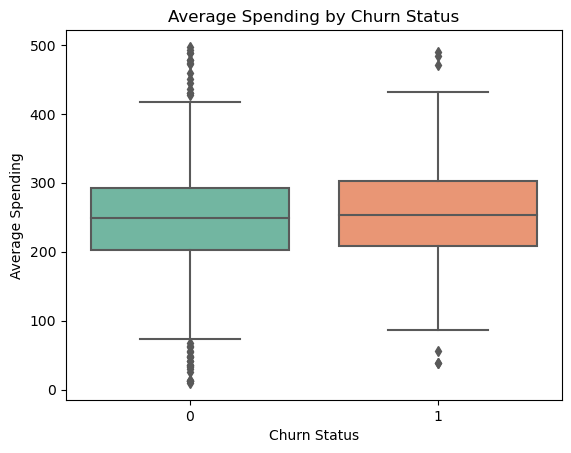

In [42]:
# Box plots for Average Spending by Churn Status
plt.figure()
sns.boxplot(x="ChurnStatus", y="AvgSpent", data=base_df, palette="Set2")
plt.title(f"Average Spending by Churn Status")
plt.xlabel("Churn Status")
plt.ylabel("Average Spending")
plt.show()

**Interpretation:**

- Surprisingly, average spending is slightly higher for churned customers than for retained ones — median and upper quartiles are shifted right.

- **This suggests:**

    - Churn is not just about low engagement or low value — even customers who spend more are churning.

    - It may point to experience dissatisfaction, external switching drivers, or poor retention strategies.

- **Insight:** You might explore churn risk among high-spending customers and investigate factors like service experience or recency.

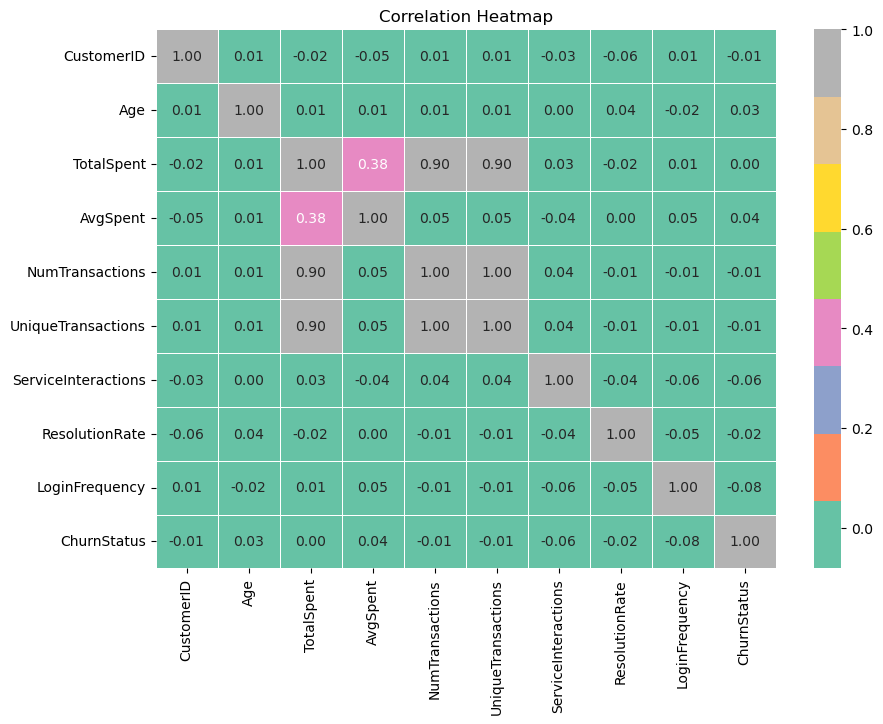

In [ ]:
# Correlation heatmap
numeric_cols = base_df.select_dtypes(include='number').columns
plt.figure(figsize=(10, 7))
sns.heatmap(base_df[numeric_cols].corr(), annot=True, cmap='Set2', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

**Recommendations:**

1. **_Keep all features for tree-based models_**, which are robust to multicollinearity.

2. For models like **_logistic regression_**, consider removing:

    - `NumTransactions` or `UniqueTransactions` if `TotalSpent` is included because they are all **very highly correlated (≈ 0.9)** → these might be redundant.

3. Consider **_interaction features_**:

    - E.g., HighSpender & LowLoginFreq may indicate at-risk high-value customers.

4. Use **_feature importance plots_** after modeling to uncover predictive power beyond linear correlation.

### **Data Preprocessing** 

Before building any predictive model, it’s critical to ensure that the dataset is clean, balanced, and properly preprocessed. 

**1. Handle Missing Values**

- `ServiceInteractions` and `ResolutionRate` have 332 missing values — these likely came from customers who had no customer service records.

    → Treat missing values as **meaningful absence**:

In [64]:
# Fill missing service-related fields with 0 (no interaction)
base_df['ServiceInteractions'] = base_df['ServiceInteractions'].fillna(0)
base_df['ResolutionRate'] = base_df['ResolutionRate'].fillna(0)

**2. Feature Engineering**

- Convert `LastLoginDate` to days since last login event and drop the column.

- Create new feature `AgeGroup` based on `Age` for better customer segmentation purpose.

In [65]:
# Convert LastLoginDate to days since last login
base_df['LastLoginDate'] = pd.to_datetime(base_df['LastLoginDate'])
ref_date = base_df['LastLoginDate'].max()
base_df['DaysSinceLastLogin'] = (ref_date - base_df['LastLoginDate']).dt.days
base_df.drop(columns=['LastLoginDate'], inplace=True)

In [66]:
# Create age bins
base_df['AgeGroup'] = pd.cut(base_df['Age'], bins=[0, 30, 50, 100], labels=['<30', '30-50', '>50'])

**3. Outliers Detection and Treatment**

- Use the `clip` method to limit the values in numeric features if there exist outliers. Given the interval, values outside the interval are clipped to the interval edges.

In [ ]:
# Cap outliers at 1st and 99th percentile for numeric features
for col in numeric_cols:
    lower = base_df[col].quantile(0.01)
    upper = base_df[col].quantile(0.99)
    base_df[col] = base_df[col].clip(lower, upper)